In [ ]:
import pandas as pd 
import matplotlib.pyplot as plt 
import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

%matplotlib inline
#All imports
'''This notebook is a convolutional neural network for melanoma classification'''
seed_value = 7
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
from numpy.random import seed
seed(seed_value)
torch.manual_seed(seed_value)


from google.colab import drive

In [ ]:
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [ ]:
os.getcwd()
# place the files in your IDE working dicrectory .
labels = pd.read_csv(r'/gdrive/My Drive/COMP 562 Project/Data/PyTorch Playground Folder/train samplev2.csv')
test_labels = pd.read_csv(r'/gdrive/My Drive/COMP 562 Project/Data/PyTorch Playground Folder/test samplev2.csv')
#submission = pd.read_csv(r'/aerialcactus/sample_submission.csv)

train_path = r'/gdrive/My Drive/COMP 562 Project/Data/PyTorch Playground Folder/Training100x100v2/'
test_path = r'/gdrive/My Drive/COMP 562 Project/Data/PyTorch Playground Folder/Testing100x100v2/'

In [ ]:
labels.head()

,img_name,target
0,ISIC_0149568.jpg,1
1,ISIC_0207268.jpg,1
2,ISIC_0188432.jpg,1
3,ISIC_0232101.jpg,1
4,ISIC_0273046.jpg,1


In [ ]:
labels.tail()

,img_name,target
7573,ISIC_8621568.jpgrotated.jpg,1
7574,ISIC_8617277.jpgrotated.jpg,1
7575,ISIC_8724944.jpgrotated.jpg,1
7576,ISIC_8615491.jpgrotated.jpg,1
7577,ISIC_8737794.jpgrotated.jpg,1


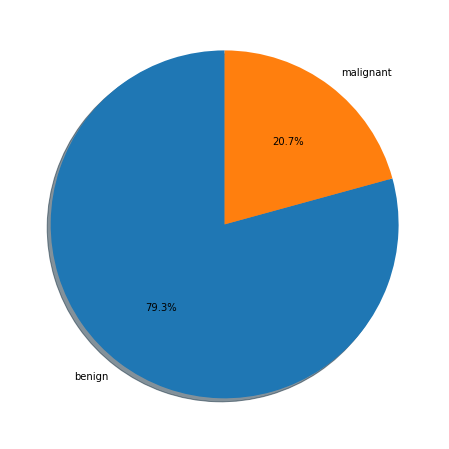

(7578, 2)


In [ ]:
labels['target'].value_counts()
label = 'benign', 'malignant'
plt.figure(figsize = (8,8))
plt.pie(labels.groupby('target').size(), labels = label, autopct='%1.1f%%', shadow=True, startangle=90)
plt.show()
print(labels.shape) #2526,2

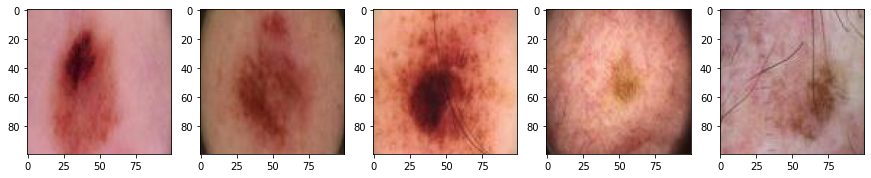

In [ ]:
import matplotlib.image as img
fig,ax = plt.subplots(1,5,figsize = (15,3))

for i,idx in enumerate(labels[labels['target'] == 1]['img_name'][-5:]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(img.imread(path))

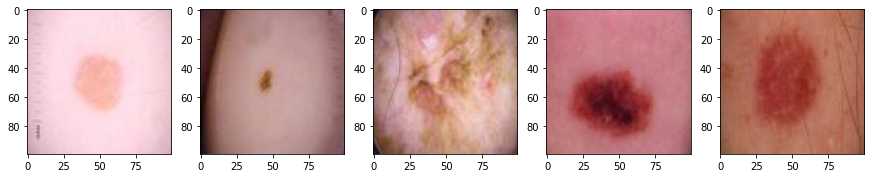

In [ ]:
fig,ax = plt.subplots(1,5,figsize = (15,3))
for i,idx in enumerate(labels[labels['target'] == 0]['img_name'][:5]):
    path = os.path.join(train_path,idx)
    ax[i].imshow(img.imread(path))

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax


means = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

In [ ]:
class MelanomaDataset(Dataset):
    def __init__(self, data, path , transform = None):
        super().__init__()
        self.data = data.values
        self.path = path
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self,index):
        img_name,label = self.data[index]
        img_path = os.path.join(self.path, img_name)
        image = img.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [ ]:
train_transform = transforms.Compose([transforms.ToPILImage(),
                                      transforms.ToTensor(),
                                      transforms.Normalize(means,std)])

valid_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(means,std)])

test_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(means,std)])

test_extra_transform = transforms.Compose([transforms.ToPILImage(),
                                     transforms.ToTensor(),
                                     transforms.Normalize(means,std)])

In [ ]:
train, valid_data = train_test_split(labels, stratify=labels.target, test_size=0.15)
test, test_extra = train_test_split(test_labels, stratify=test_labels.target, test_size=2)

In [ ]:
train_data = MelanomaDataset(train, train_path, train_transform ) #Can include transforms for data
valid_data = MelanomaDataset(valid_data, train_path, valid_transform )
test_data = MelanomaDataset(test, test_path, test_transform)
test_extra_data = MelanomaDataset(test_extra, test_path, test_extra_transform)

In [ ]:
num_epochs = 4
num_classes = 2
batch_size = 25
learning_rate = 0.001

# CPU or GPU

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
train_loader = DataLoader(dataset = train_data, batch_size = batch_size, shuffle=True, num_workers=0)
valid_loader = DataLoader(dataset = valid_data, batch_size = batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(dataset = test_data, batch_size = batch_size, shuffle=False, num_workers=0)
testoverflow_loader = DataLoader(dataset = test_extra_data, batch_size = batch_size, shuffle=False, num_workers=0)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


training images
torch.Size([3, 100, 100])


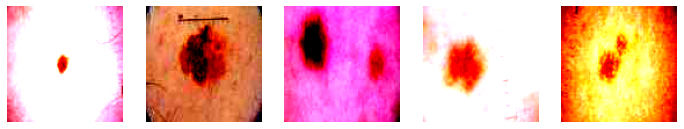

In [ ]:
trainimages, trainlabels = next(iter(train_loader))

fig, axes = plt.subplots(figsize=(12, 12), ncols=5)
print('training images')
for i in range(5):
    axe1 = axes[i] 
    imshow(trainimages[i], ax=axe1, normalize=False)

print(trainimages[0].size())

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module): 
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=5, kernel_size=5)
        self.conv2 = nn.Conv2d(5, 5, kernel_size=5)
        self.conv2_drop = nn.Dropout2d(p=0.15)
        self.fc1 = nn.Linear(2420, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 150)
        self.fc4 = nn.Linear(150, 2)

    def forward(self, x):
        x = F.leaky_relu(F.max_pool2d(self.conv1(x), 2))
        #print(x.shape)
        x = F.leaky_relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        #print(x.shape)
        x = x.view(x.shape[0],-1)
        #print(x.shape)
        x = F.leaky_relu(self.fc1(x))
        #print(x.shape)
        x = F.dropout(x, training=self.training)
        #print(x.shape)
        x = self.fc2(x)
        #print(x.shape)
        x = self.fc3(x)
        #print(x.shape)
        x = self.fc4(x)
        #print(x.shape)
        return x

#BatchNorm2D
#LeakyReLU

In [ ]:
model = CNN()
print(model)

CNN(
  (conv1): Conv2d(3, 5, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(5, 5, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.15, inplace=False)
  (fc1): Linear(in_features=2420, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (fc3): Linear(in_features=512, out_features=150, bias=True)
  (fc4): Linear(in_features=150, out_features=2, bias=True)
)


In [ ]:
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = learning_rate)

In [ ]:
from tqdm.notebook import tqdm
#%%time
# keeping-track-of-losses 
train_losses = []
valid_losses = []

for epoch in range(1, num_epochs + 1):
    # keep-track-of-training-and-validation-loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # training-the-model
    model.train()
    for data, target in tqdm(train_loader, total=len(train_loader)):
        # move-tensors-to-GPU 
        data = data.to(device)
        target = target.to(device)
        
        # clear-the-gradients-of-all-optimized-variables
        optimizer.zero_grad()
        # forward-pass: compute-predicted-outputs-by-passing-inputs-to-the-model
        output = model(data)
        # calculate-the-batch-loss
        loss = criterion(output, target)
        # backward-pass: compute-gradient-of-the-loss-wrt-model-parameters
        loss.backward()
        # perform-a-ingle-optimization-step (parameter-update)
        optimizer.step()
        # update-training-loss
        train_loss += loss.item() * data.size(0)
        
    # validate-the-model
    model.eval()
    for data, target in valid_loader:
        
        data = data.to(device)
        target = target.to(device)
        
        output = model(data)
        
        loss = criterion(output, target)
        
        # update-average-validation-loss 
        valid_loss += loss.item() * data.size(0)
    
    # calculate-average-losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(valid_loader.sampler)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
        
    # print-training/validation-statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))

    
#tqdm notebook
#from tqdm.notebook import tqdm ***
#for data, target in tqdm(train_loader, total=len(train_loder)):
#Prints out a progress bar for how long stuff is taking to run

In [ ]:
# test-the-model
model.eval()  # it-disables-dropout

final_pred = []
final_label = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in valid_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for p in predicted:
          final_pred.append(p.cpu().data.numpy())
        for l in labels:
          final_label.append(l.cpu().data.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Validation Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
#torch.save(model.state_dict(), 'model.pth')



In [ ]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(frameon=False)

In [ ]:
from sklearn.metrics import recall_score, confusion_matrix, precision_score, accuracy_score, precision_recall_curve, average_precision_score, plot_confusion_matrix, ConfusionMatrixDisplay
print('Confusion Matrix')
cf_matrix = confusion_matrix(final_label, final_pred)
accuracy = accuracy_score(final_label, final_pred)
ppv = precision_score(final_label, final_pred, average=None)
recall = recall_score(final_label, final_pred, average=None)
print("Validation Accuracy | ", accuracy*100, " PPV | ",ppv," Recall | ",recall)
print(cf_matrix)
class_names = np.array(['Benign', 'Malignant'])
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                              display_labels=class_names)
# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal') #Each of these are the default values

plt.show()

In [ ]:
# test-the-model
model.eval()  # it-disables-dropout

final_pred = []
final_label = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for p in predicted:
          final_pred.append(p.cpu().data.numpy())
        for l in labels:
          final_label.append(l.cpu().data.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
#torch.save(model.state_dict(), 'model.pth')

In [ ]:
print('Confusion Matrix')
cf_matrix = confusion_matrix(final_label, final_pred)
accuracy = accuracy_score(final_label, final_pred)
ppv = precision_score(final_label, final_pred, average=None)
recall = recall_score(final_label, final_pred, average=None)
print("Validation Accuracy | ", accuracy*100, " PPV | ",ppv," Recall | ",recall)
print(cf_matrix)
class_names = np.array(['Benign', 'Malignant'])
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                              display_labels=class_names)
# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal') #Each of these are the default values

plt.show()

In [ ]:
# test-the-model
model.eval()  # it-disables-dropout

final_pred = []
final_label = []
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in testoverflow_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        for p in predicted:
          final_pred.append(p.cpu().data.numpy())
        for l in labels:
          final_label.append(l.cpu().data.numpy())
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
          
    print('Test Accuracy of the model: {} %'.format(100 * correct / total))

# Save 
#torch.save(model.state_dict(), 'model.pth')

#1212 136
#97 83 20 epochs

In [ ]:
print('Confusion Matrix')
cf_matrix = confusion_matrix(final_label, final_pred)
accuracy = accuracy_score(final_label, final_pred)
ppv = precision_score(final_label, final_pred, average=None)
recall = recall_score(final_label, final_pred, average=None)
print("Validation Accuracy | ", accuracy*100, " PPV | ",ppv," Recall | ",recall)
print(cf_matrix)
class_names = np.array(['Benign', 'Malignant'])
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,
                              display_labels=class_names)
# NOTE: Fill all variables here with default values of the plot_confusion_matrix
disp = disp.plot(include_values=True, cmap='viridis', ax=None, xticks_rotation='horizontal') #Each of these are the default values

plt.show()

In [ ]:
#408 40 10 epochs, 10% dropout leaky relus
#36 24

In [ ]:
#import os
#directory_1 = '/gdrive/My Drive/COMP 562 Project/Data/Testing/Malignant/'
#directory_0 = '/gdrive/My Drive/COMP 562 Project/Data/Testing/Benign/'
#filenames_1 = []
#filenames_0 = []
#for filename in os.listdir(directory_1):
#    if filename.startswith("ISIC"): 
#         filenames_1.append(filename)
#
#for filename in os.listdir(directory_0):
#    if filename.startswith("ISIC"): 
#         filenames_0.append(filename)
#
#df_1 = pd.DataFrame(filenames_1)
#df_0 = pd.DataFrame(filenames_0)

In [ ]:
#df_1.to_csv('/gdrive/My Drive/COMP 562 Project/Data/PyTorch Playground Folder/malignanttest.csv')
#df_0.to_csv('/gdrive/My Drive/COMP 562 Project/Data/PyTorch Playground Folder/benigntest.csv')
